# **HW5 : Reinforcement Learning (QLearning And SARSA)**

> - Full Name: **Arash Ghavami**
> - Student ID: **402106359**

## **Overview**  

In this notebook, we will experiment with different reinforcement learning algorithms under various configurations to gain deeper insights into their behavior.  

By completing this homework, you will:  
- Understand **exploration vs. exploitation** and how they impact the learning process in an environment.  
- Learn how to **balance exploration and exploitation** effectively for optimal performance.  
- Recognize the importance of **epsilon decay** and when to use.  

Also, you will:  
- Gain a solid understanding of **n-step SARSA** and **n-step Q-learning**.  
- Explore how different values of **n** affect learning quality and efficiency.  
- Compare the strengths and trade-offs of **n-step SARSA vs. n-step Q-learning** to determine when to use each method.

---

We will start by learning how to implement **epsilon-greedy**, **n-step SARSA**, and **n-step Q-learning**.  

Next, we will implement a class that takes learning **hyperparameters** and includes a `learn` method, which accepts an algorithm (such as SARSA) and trains the environment accordingly.  

After that, we will experiment with **different epsilon values** to analyze their effect on the learning process. Finally, we will explore **different values of n** to gain deeper insights into **n-step SARSA** and **n-step Q-learning** and their impact on learning quality.


## **Preliminary (Introduction to OpenAI Gym)**

Here we provide some links for you to get know the basics of openai gymnasium which we will be using for this home work.

- [Official Documentation](https://gymnasium.farama.org/introduction/basic_usage/)

- [A Gentle Introduction to OpenAI Gym](https://wandb.ai/mukilan/intro_to_gym/reports/A-Gentle-Introduction-to-OpenAI-Gym--VmlldzozMjg5MTA3)

- [Introduction of OpenAI Gym 💪](https://www.kaggle.com/code/utkarshsaxenadn/introduction-of-openai-gym/notebook)

## **Environment Setup**
Setting up required libraries and environment.

In [59]:
!sudo apt-get update --quiet
!pip install 'imageio==2.4.0' --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip3 install gymnasium[classic_control] --quiet

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,569 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,963 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,420 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/

In [60]:
import gymnasium as gym
import random
import base64
import imageio
import IPython
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve as conv
from collections import defaultdict

In [61]:
import logging
logging.getLogger().setLevel(logging.ERROR)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1, fps=5, max_steps=48):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, _ = env.reset()
            video.append_data(env.render())
            while max_steps >= 0:
                action = policy(state, Q)
                state, _, terminated, truncated, _ = env.step(action)
                max_steps -= 1
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_heatmap(env, value, ax=None, show=False):
    if ax is None:
        _, ax = plt.subplots()
    dim_x, dim_y = 12, 4
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    labels[37:-1], labels[-1] = ' ', 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
    if show:
        plt.show()
    return im


def plot_rewards(rewards, average_range=10, log=False, ax=None, show=False):
    n_episodes = len(rewards)
    if log:
        rewards = np.log10(-rewards)
    if ax is None:
        fig, ax = plt.subplots()
    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
    ax.plot(range(0, n_episodes, average_range), smoothed_rewards[0:n_episodes:average_range])
    ylab = 'Log of negative sum of rewards' if log else 'Total reward'
    ax.set(xlabel='Episodes', ylabel=ylab)
    if show:
      plt.show()


def plot_performance(env, value, reward_sums, log=False):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
    plot_rewards(reward_sums, ax=axes[0], log=log)
    plot_heatmap(env, value, ax=axes[1])
    plt.show(fig)

def plot_regret(regret_sums, average_range=10, ax=None, show=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(np.cumsum(regret_sums), color='orange', label="Cumulative Regret")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Cumulative Regret")
    ax.set_title("Regret Over Time")
    ax.legend()
    ax.grid()

    if show:
        plt.show()

    return ax


In [62]:
env = gym.make('CliffWalking-v1', render_mode='rgb_array')
env.reset()

print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Discrete(48)
Actions: Discrete(4)


## **Policy Definitions**
Implementing different policies for action selection.[link text](https://)

In [63]:
Actions =[0,1,2,3]

def random_policy(state=None, Q=None):
    print(env.action_space)
    action = env.action_space.sample()
    return  action

In [64]:
create_policy_eval_video(env = env, policy = random_policy,filename='random', max_steps=50)

Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)
Discrete(4)


In [65]:
import numpy as np

def greedy_policy(state, Q):
    return np.argmax(Q[state])

In [66]:
def epsilon_greedy(state, Q, epsilon = 0.1):
    rand = np.random.uniform()
    if rand < 0.1:
      rand = np.random.uniform(low=0, high=4)
      rand = np.floor(rand)
      rand = int(rand)
      rand = Actions[rand]
    else:
      rand = greedy_policy(state, Q)

    return rand

## **Evaluation & Visualization**
Analyzing policy performance.

In [67]:
import numpy as np

def evaluate_policy(env, Q, num_episodes=1, max_steps=100):
    episode_returns = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = greedy_policy(state, Q)
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                break

        episode_returns.append(total_reward)

    mean = np.mean(episode_returns)
    std = np.std(episode_returns)

    return mean, std


In [68]:
from collections import deque

class learnEnvironment:
  def __init__(self,env,episodes,n,alpha,max_step,epsilon=0.1,discount=0.95):
    self.n = n
    self.episodes = episodes
    self.Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    self.Return_list = []
    self.alpha = alpha
    self.discount = discount
    self.max_step = max_step
    self.epsilon = epsilon

  def learn(self,env, learning_rule, epsilon_greedy_policy):
      for _ in range(self.episodes):
        t = 0
        Return = 0
        n_step_reward = deque([], self.n)
        state, _ = env.reset()

        while True:

          action = epsilon_greedy_policy(state,self.Q_table, self.epsilon)
          next_state, reward, terminated, truncated, _ = env.step(action)
          Return += reward

          if terminated or truncated or t> self.max_step:

            self.Return_list.append(Return)
            break

          n_step_reward.append(reward)
          T =  t - self.n + 1
          if T >= 0:

              self.Q_table = learning_rule(n_step_reward, self.Q_table, state, action, next_state, self.discount, self.n, self.alpha, terminated)
          t+=1
          state = next_state

      return self.Q_table, self.Return_list

In [69]:
#@title N-step Sarsa_algortihm
def calculate_n_step_Return(n_step_reward,discount = 0.95):
  G = 0
  for r in reversed(n_step_reward):
    G = discount*G + r

  return G

def sarsa(n_step_reward, Q, state, action, next_state, discount, n, alpha, epsilon=0.1):

    G = calculate_n_step_Return(n_step_reward, discount)
    if len(n_step_reward) == n:
        next_action = np.argmax(Q[next_state])
        G += (discount ** n) * Q[next_state, next_action]
    td_error = G - Q[state, action]

    Q[state, action] += alpha * td_error

    return Q



In [70]:
def n_step_q_learning(n_step_reward, Q, state, action, next_state, discount, n, alpha, terminated=None):
    G = calculate_n_step_Return(n_step_reward, discount)

    if len(n_step_reward) == n:
        best_next_action = np.argmax(Q[next_state])
        G += (discount ** n) * Q[next_state, best_next_action]

    td_error = G - Q[state, action]
    Q[state, action] += alpha * td_error

    return Q


# **Exploration vs. Exploitation Trade-off**
In reinforcement learning, an agent must balance between:
- **Exploration**: Trying new actions to discover potentially better long-term rewards.
- **Exploitation**: Choosing the best-known action based on current knowledge to maximize immediate reward.

### **Why is this Trade-off Important?**
- Too much **exploration** → The agent wastes time taking suboptimal actions and miss the optimal reward.
- Too much **exploitation** → The agent might **get stuck in a suboptimal policy** without discovering new possibilities for a better strategy.

### **Epsilon-Greedy Policy**:  
   - With probability $\epsilon$, the agent **explores** (chooses a random action).  
   - With probability $\epsilon$, the agent **exploits** (chooses the best-known action).  
   - $\epsilon$ is often **decayed over time** to gradually shift from exploration to exploitation.

---

# **Regret in Reinforcement Learning**
Regret in reinforcement learning measures the **difference between the reward an agent actually receives** and the **maximum possible reward it could have received** under an optimal policy. It quantifies **learning inefficiency** and helps evaluate how well an agent balances exploration and exploitation.

### **Mathematical Definition**
Given:
- $R_t^{\text{optimal}}$ is the reward the agent **could have obtained** in timestep $ t $ under the optimal policy.
- $R_t$ is the **actual reward** obtained by the agent in timestep $ t $.

The **instantaneous regret** at time $ t $ is:

$$
\text{Regret}(t) = R_t^{\text{optimal}} - R_t
$$

The **cumulative regret** over $ T $ timesteps is:

$$
\text{Cumulative Regret}(T) = \sum_{t=1}^{T}  ( R_t^{\text{optimal}} - R_t)
$$
A well-trained RL agent should aim to **minimize regret** over time.

---






SARSA mean_reward = -13.00 +/- 0.0000



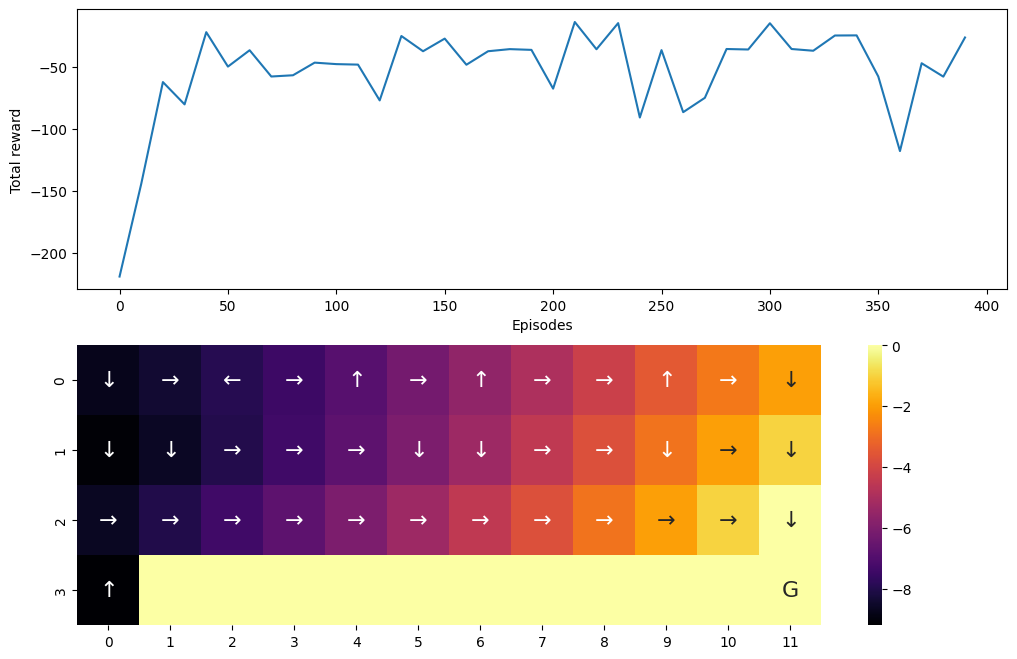

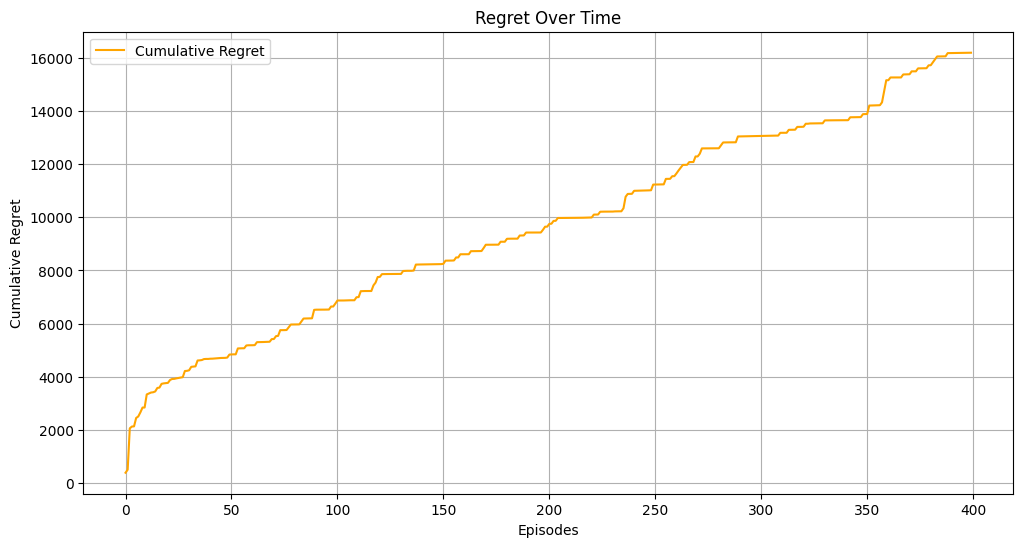

In [74]:
# @title epsilon = 0.1
optimal_reward = -13
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

regret_sums_sarsa = []

regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

plot_regret(regret_sums_sarsa, show=True)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


SARSA mean_reward = -13.00 +/- 0.0000



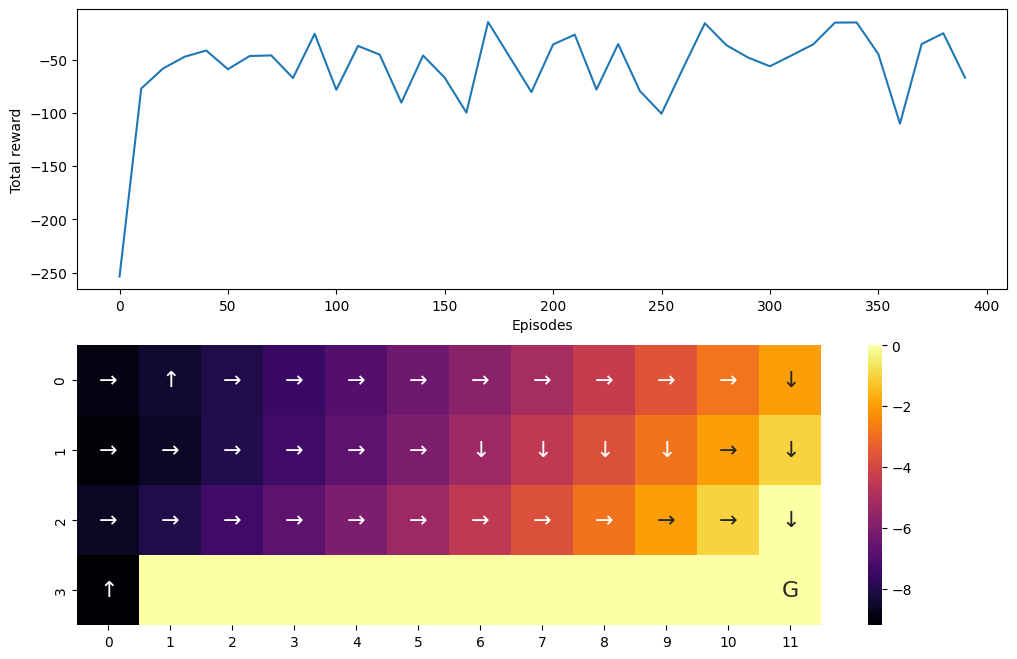

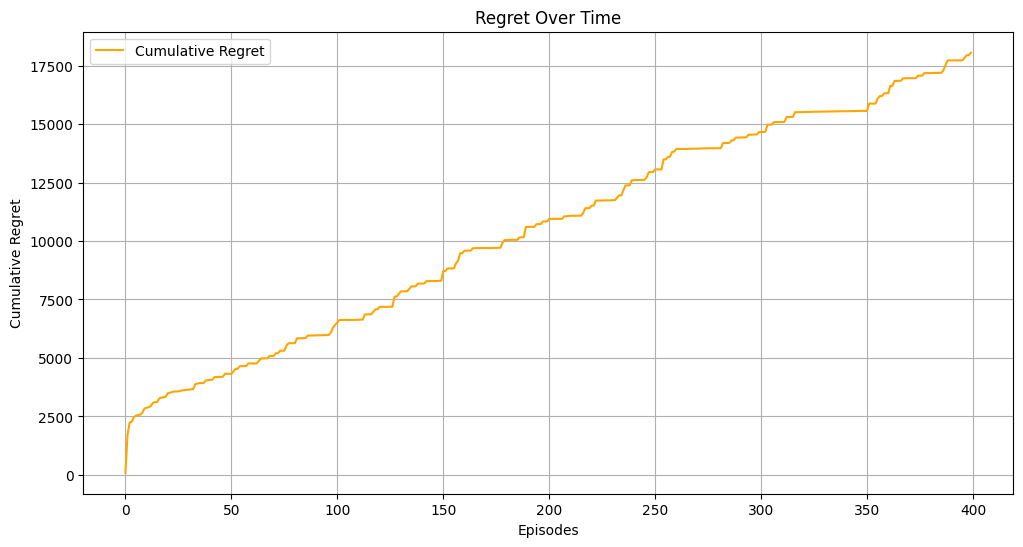

In [75]:
# @title epsilon = 0.5
optimal_reward =  -13

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.5)



results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

regret_sums_sarsa = []

regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

plot_regret(regret_sums_sarsa, show=True)


env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



SARSA mean_reward = -13.00 +/- 0.0000



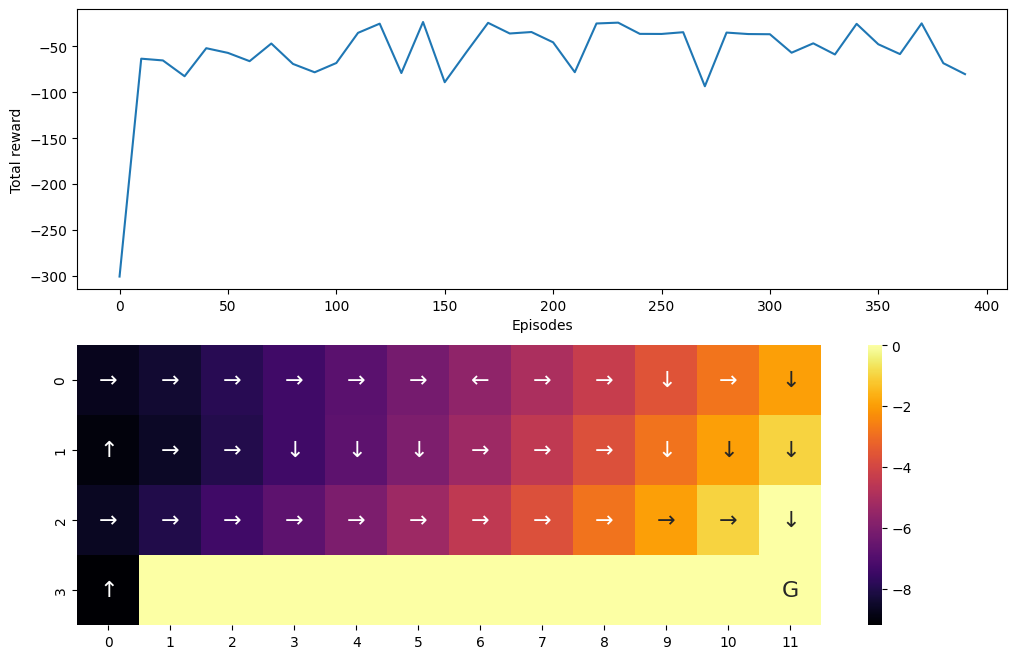

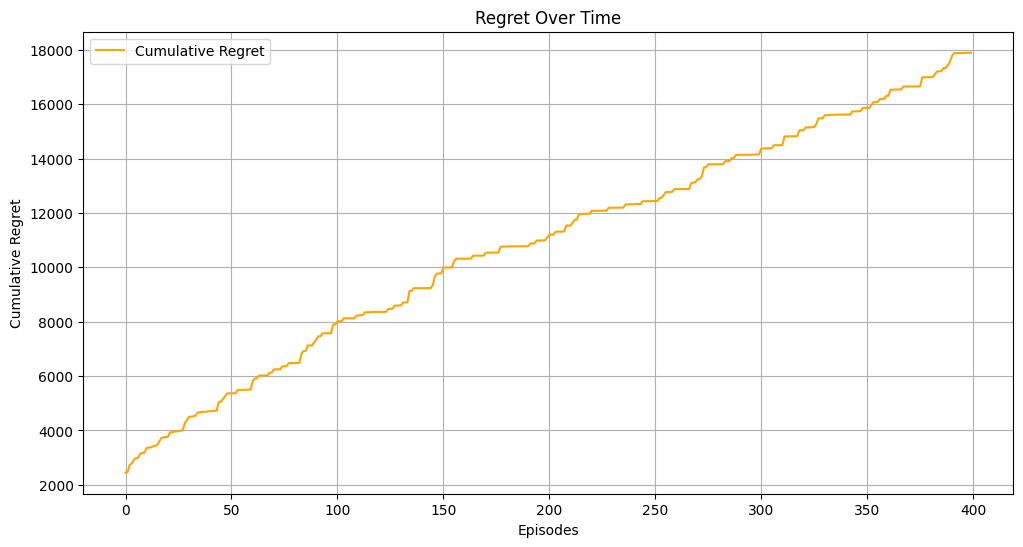

In [76]:
# @title epsilon = 0.9
optimal_reward = -13
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.9)

results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

regret_sums_sarsa = []
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

plot_regret(regret_sums_sarsa, show=True)


env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


Fast Decay


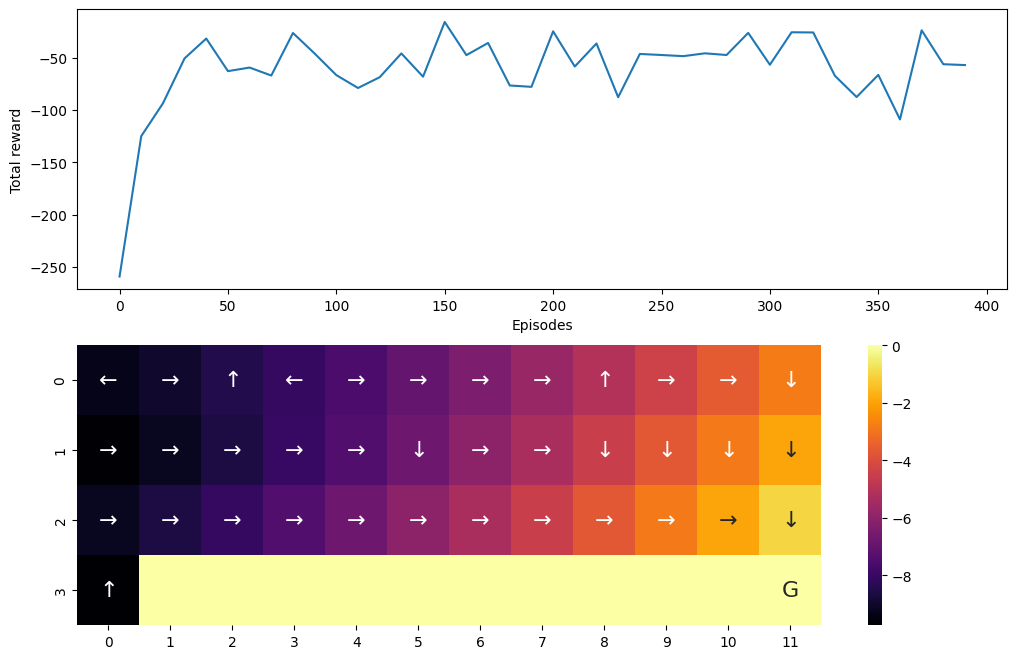


Fast Decay SARSA mean_reward = -13.00 +/- 0.0000
Medium Decay


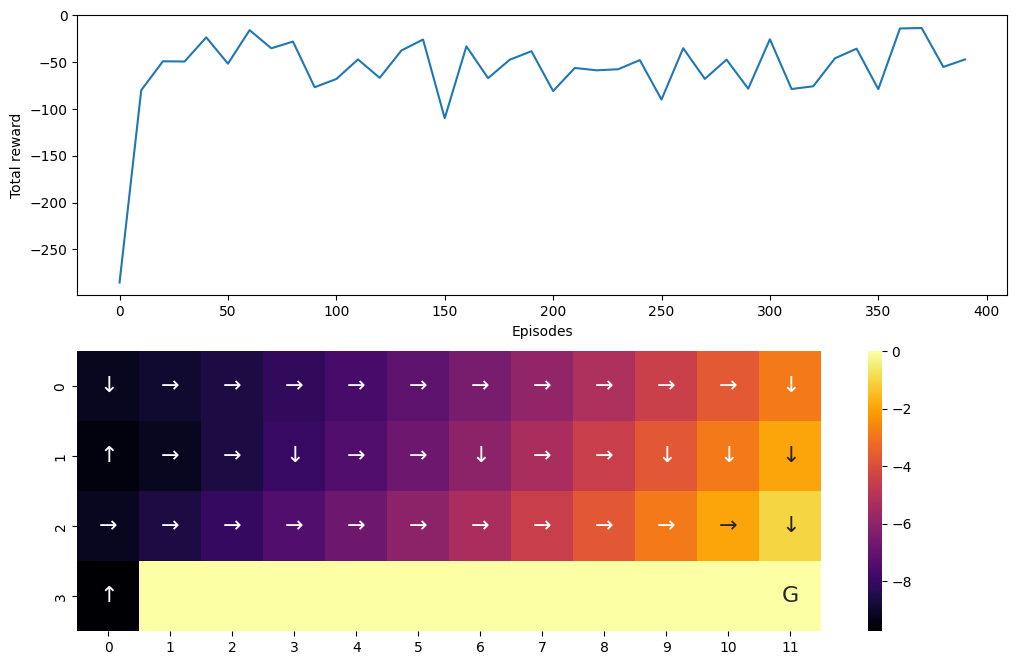


Medium Decay SARSA mean_reward = -13.00 +/- 0.0000
Slow Decay


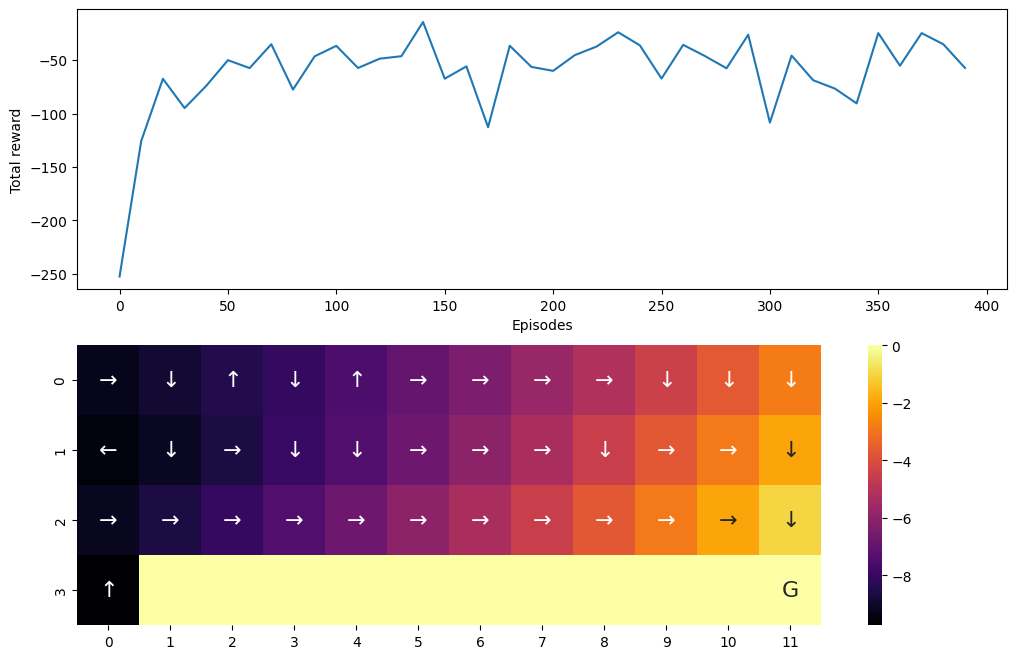


Slow Decay SARSA mean_reward = -13.00 +/- 0.0000


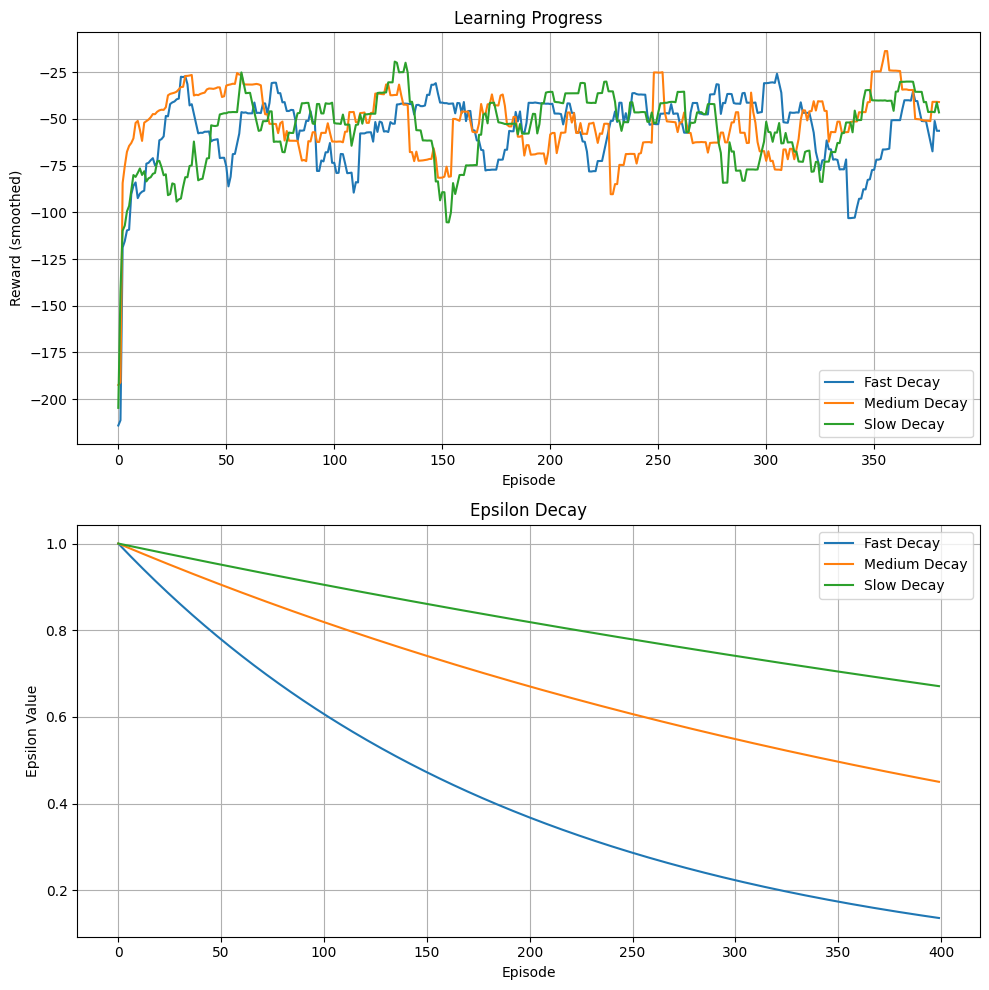

In [77]:
# @title Epsilon Decay
class EpsilonDecayStrategy:
    def __init__(self, initial_epsilon, min_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon = initial_epsilon

    def get_epsilon(self, episode):
        """Calculate epsilon using exponential decay."""
        self.epsilon = max(
            self.min_epsilon,
            self.initial_epsilon * np.exp(-self.decay_rate * episode)
        )
        return self.epsilon

class learnEnvironmentWithEpsilonStrategy:
    def __init__(self, policy, env, n_episodes, n, alpha, max_step, epsilon_strategy):
        self.policy = policy
        self.env = env
        self.n_episodes = n_episodes
        self.n = n
        self.alpha = alpha
        self.max_step = max_step
        self.epsilon_strategy = epsilon_strategy

    def learn(self, env, algorithm):
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        Q = np.zeros((n_states, n_actions))
        reward_sums = np.zeros(self.n_episodes)
        epsilon_values = np.zeros(self.n_episodes)

        for episode in range(self.n_episodes):
            state, _ = env.reset()
            episode_reward = 0
            n_step_reward = []

            current_epsilon = self.epsilon_strategy.get_epsilon(episode)
            epsilon_values[episode] = current_epsilon

            for step in range(self.max_step):
                action = self.policy(state, Q, current_epsilon)
                next_state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
                n_step_reward.append(reward)

                if len(n_step_reward) >= self.n:
                    Q = algorithm(
                        n_step_reward[-self.n:],
                        Q, state, action, next_state,
                        0.95, self.n, self.alpha,
                        current_epsilon
                    )

                if terminated or truncated:
                    break

                state = next_state

            reward_sums[episode] = episode_reward

        return Q, reward_sums, epsilon_values

def plot_results(reward_sums_list, epsilon_values_list, labels):
    """Plot rewards and epsilon decay for multiple runs."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    for rewards, label in zip(reward_sums_list, labels):
        window_size = 20
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(smoothed_rewards, label=label)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward (smoothed)')
    ax1.set_title('Learning Progress')
    ax1.legend()
    ax1.grid(True)

    for epsilons, label in zip(epsilon_values_list, labels):
        ax2.plot(epsilons, label=label)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon Value')
    ax2.set_title('Epsilon Decay')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

np.random.seed(42)

epsilon_strategies = [
    EpsilonDecayStrategy(1.0, 0.01, 0.005),
    EpsilonDecayStrategy(1.0, 0.01, 0.002),
    EpsilonDecayStrategy(1.0, 0.01, 0.001)
]

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')

all_rewards = []
all_epsilons = []
strategy_labels = ['Fast Decay', 'Medium Decay', 'Slow Decay']

for strategy, label in zip(epsilon_strategies, strategy_labels):
    learning_algorithm = learnEnvironmentWithEpsilonStrategy(
        epsilon_greedy, env, n_episodes, n, alpha, max_step, strategy
    )
    value_sarsa, reward_sums, epsilon_values = learning_algorithm.learn(env, sarsa)
    all_rewards.append(reward_sums)
    all_epsilons.append(epsilon_values)

    print(label)
    plot_performance(env, value_sarsa, reward_sums)

    mean_reward, std_reward = evaluate_policy(env, value_sarsa)
    print(f"\n{label} SARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

plot_results(all_rewards, all_epsilons, strategy_labels)
plt.show()

### **Why does epsilon 0.1 have the best performance?**  
In this environment, the reward for stepping into the cliff is -100, which is highly punishing. Because of this, exploration is not highly favored, making a lower epsilon (0.1) more effective as it prioritizes safer, learned actions over risky exploration.

# N-step Sarsa and N-step Q-learning

## Effect of  n = 1


SARSA mean_reward = -13.00 +/- 0.0000



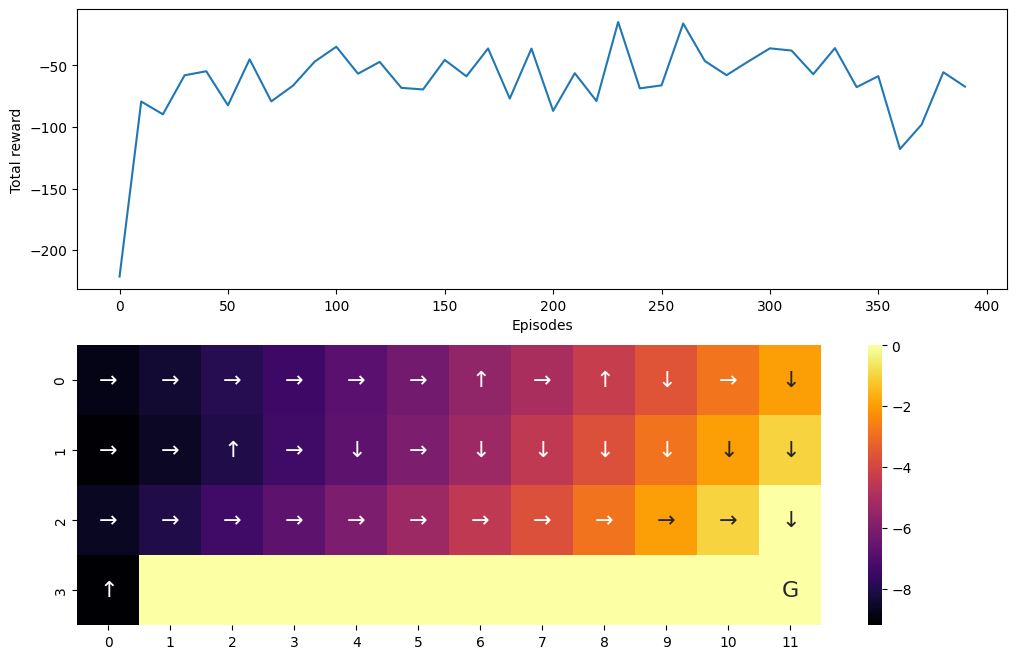

In [78]:
#@title Sarsa
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


qlearning mean_reward = -13.00 +/- 0.0000



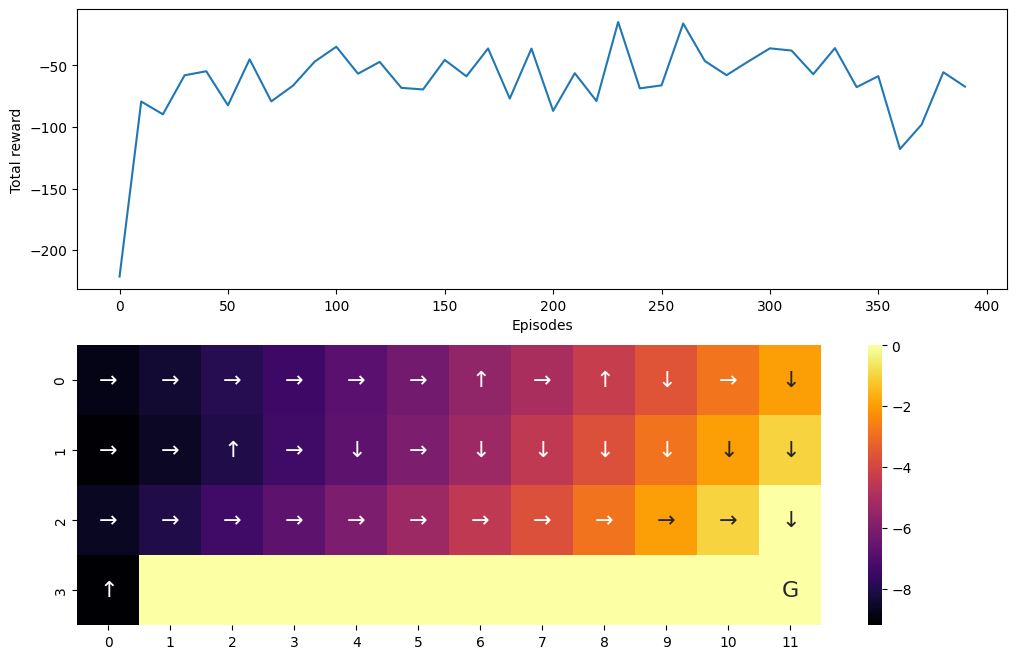

In [79]:
#@title Q-learning
np.random.seed(42)


n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000


env = gym.make('CliffWalking-v1')


learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results


mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")
plot_performance(env, value_qlearning, reward_sums_qlearning)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 2


SARSA mean_reward = -13.00 +/- 0.0000



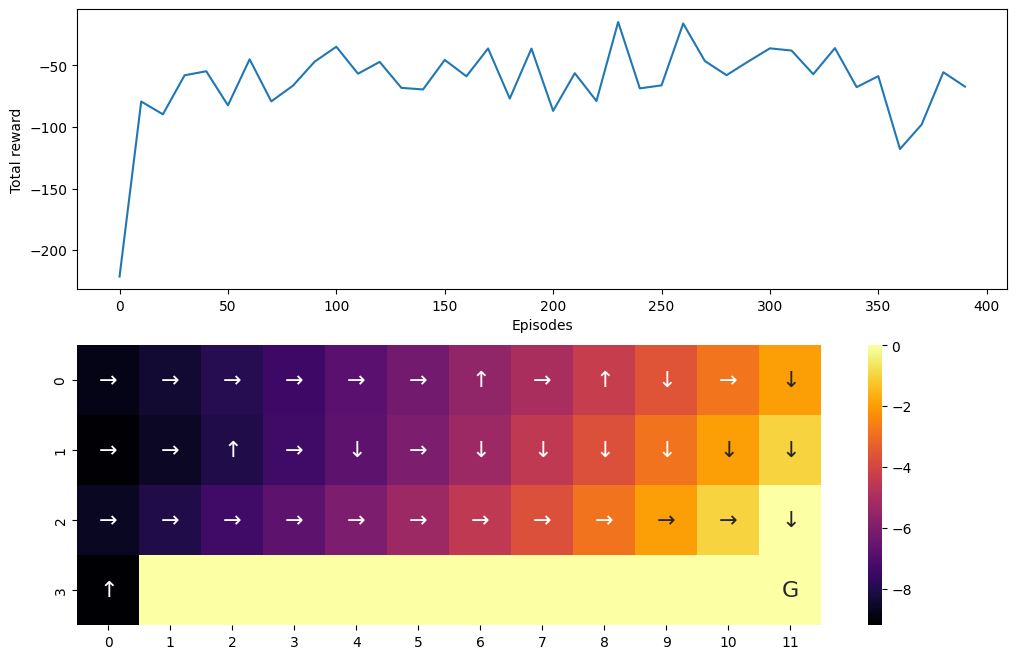

In [80]:
#@title Sarsa
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -13.00 +/- 0.0000



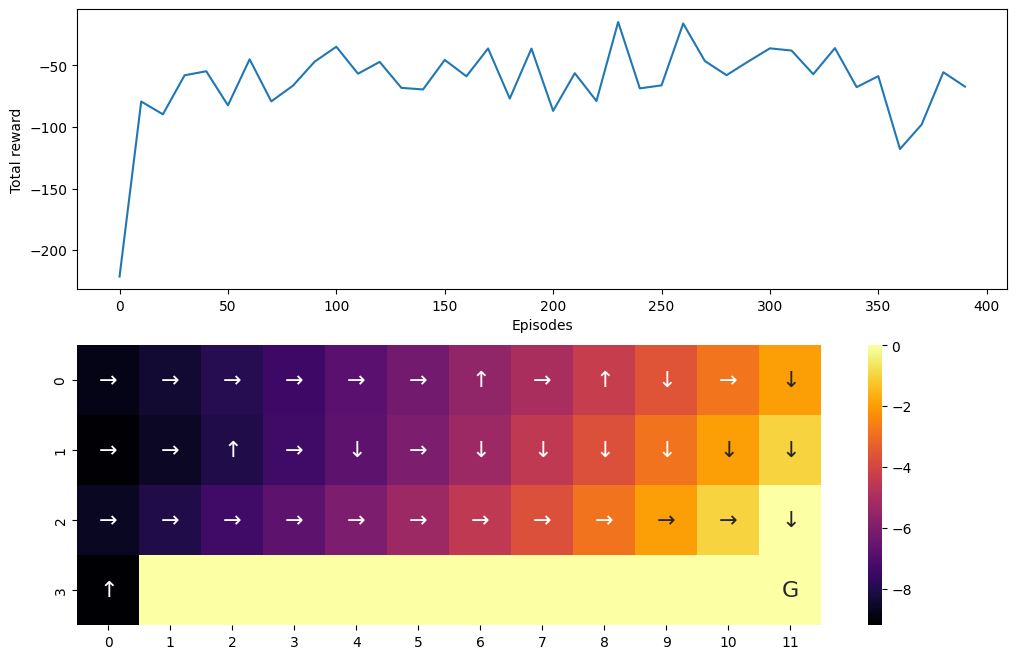

In [81]:
#@title Q-learning
np.random.seed(42)
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_qlearning, reward_sums_qlearning)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 5


SARSA mean_reward = -13.00 +/- 0.0000



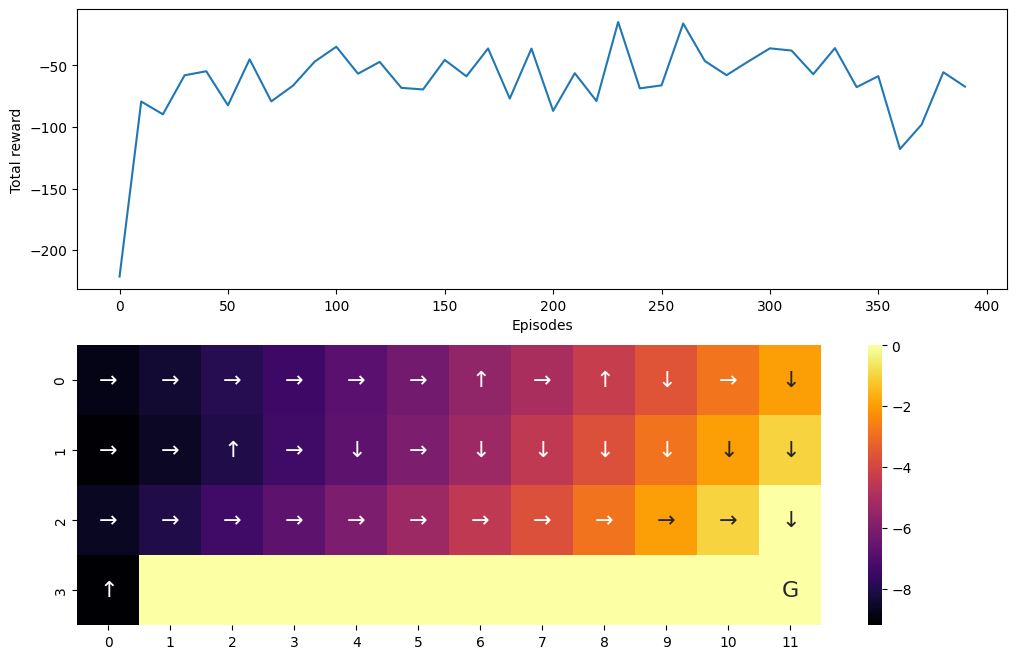

In [82]:
#@title Sarsa
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -13.00 +/- 0.0000



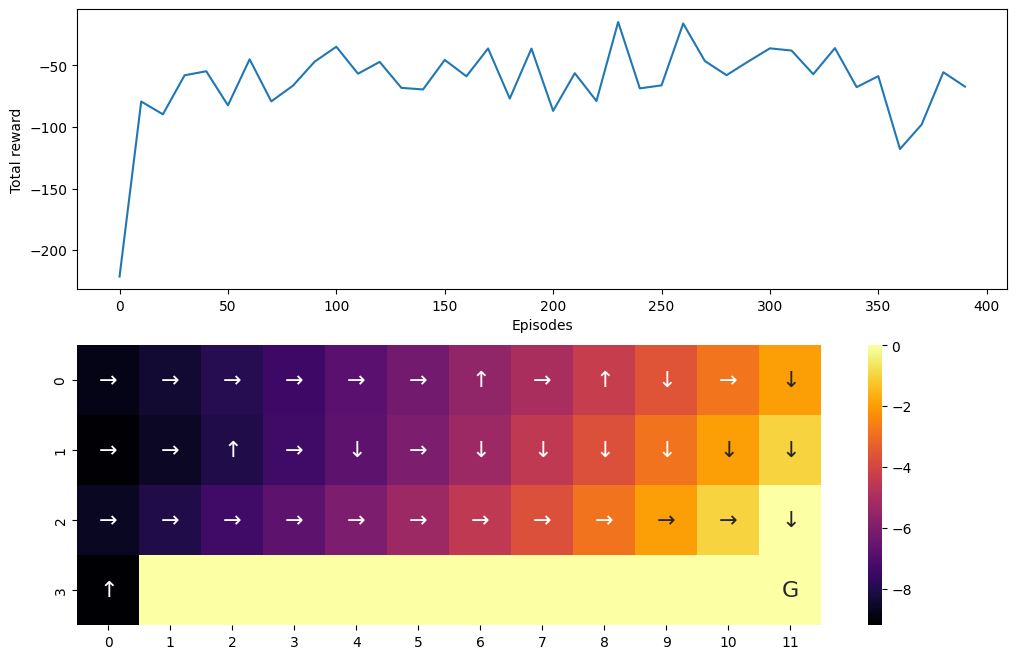

In [84]:
#@title Q-learning
np.random.seed(42)

n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

env = gym.make('CliffWalking-v1')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)

results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_qlearning, reward_sums_qlearning)

env = gym.make('CliffWalking-v1', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)
